In [94]:
# Importing 
%matplotlib inline
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import PIL.ImageOps 
from PIL import Image
import numpy as np
import random
import torch
from torch.autograd import Variable  
import torch.nn.functional as F

In [95]:
test_dir = 'testset/'   

In [96]:
def imshow(img, text=None):
    np_img = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [97]:
class DatasetCreation(Dataset):
    
    def __init__(self, image_folder, transform = None, invert = False):
        self.image_folder = image_folder
        self.transform = transform
        self.invert = invert
        
    def __getitem__(self, index):
        sample_1 = random.choice(self.image_folder.imgs)
        same_class = random.randint(0, 1)
        
        if same_class:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] == sample_2[1]:
                    break
        else:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] != sample_2[1]:
                    break
        
        img_1 = Image.open(sample_1[0]).convert("L")
        img_2 = Image.open(sample_2[0]).convert("L")
        
        if self.invert:
            img_1 = PIL.ImageOps.invert(img_1)
            img_2 = PIL.ImageOps.invert(img_2)
        
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
            
        return img_1, img_2, torch.from_numpy(np.array([int(sample_1[1] != sample_2[1])], dtype = np.float32))
    
    def __len__(self):
        return len(self.image_folder.imgs)

torch.Size([1, 1, 100, 100])
0.38672760128974915
Matched with confidence


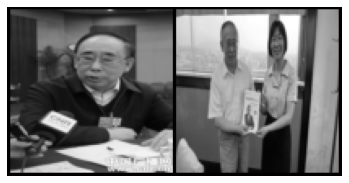

torch.Size([1, 1, 100, 100])
1.4365555047988892
Not Matched with confidence


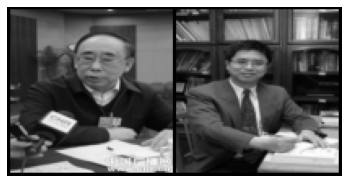

torch.Size([1, 1, 100, 100])
1.2123619318008423
Not Matched with confidence


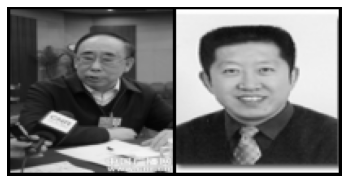

torch.Size([1, 1, 100, 100])
1.2123619318008423
Not Matched with confidence


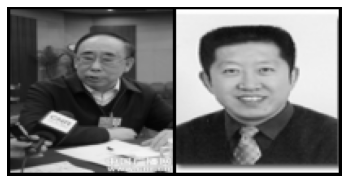

In [100]:
model = torch.load('model_triplet_pr_po_max_pool_fix_weighted.pt').eval() # load the trained modelin evaluation mode
test_folder = dataset.ImageFolder(test_dir)
created_dataset = DatasetCreation(image_folder=test_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False) # resizing the imae to 100*100 and cob=verting into tensor

dataloader = DataLoader(created_dataset,
                            shuffle= True,
                            num_workers=0,
                            batch_size=1)

data_iter = iter(dataloader) # will load iterate through the images in dataloader 
img0, _, _ = next(data_iter) # will return the next image in the dataloader img0 is a 4d tensor wih size ([1,1,100,100])
                             # where 1=batch size , 1 = channel (gray scale image), 100= width, 100=height


with torch.no_grad(): # no need of computing gradients while validating
    for i in range(4):
        _, img1, label = next(data_iter)
        print(img1.size())
        merged = torch.cat((img0,img1), 0) #concatenating two tensors along dimension zero and the shape of resulting tensor is 
                                           # [2,1,100,100]

        output1, output2 = model(Variable(img0).cuda(), Variable(img1).cuda()) #input image tensors are wrapped in Variable
                                                                               # and passed to the model
        distance = F.pairwise_distance(output1, output2) # calculating the pairwise distance between two image output vectors(last layer)
        c=distance.item()
        print(c)
        if c < 0.6:
            print("Matched with confidence")
            imshow(torchvision.utils.make_grid(merged))
        else: 
            print("Not Matched with confidence")
            imshow(torchvision.utils.make_grid(merged))
